In [97]:
#from TMP117 import TMP117

In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random 

class TMP117():
    def __init__(self, time_step, duration, activeTimeParams): 
        self.time_step = time_step
        self.duration = duration
        self.time = np.arange(0, duration, time_step) #time at which to collect data
        self.activeTimeParams = activeTimeParams
        
    def errorCheck(self):
        for times in self.activeTimeParams:
            averages = [0,8,32,64]
            cycleTimes = [0.0155, 0.125, 0.25, 0.5, 1, 4, 8, 16]
            modes = ["OS", "CC"]
            if self.activeTimeParams[times][0] not in averages:
                print("ERROR: Num averages chosen not valid. You chose {}. Valid params to choose from: {}".format(self.activeTimeParams[times][0], averages))
                
            if self.activeTimeParams[times][1] not in cycleTimes:
                print("ERROR: Conv Cycle time chosen not valid. You chose {}. Valid params to choose from: {}".format(self.activeTimeParams[times][1], cycleTimes))
             
            if self.activeTimeParams[times][2] not in modes:
                print("ERROR: Mode chosen not valid. You chose {}. Valid params to choose from: {}".format(self.activeTimeParams[times][2], modes))
                
    def computePower(self, num_averages, convCycleTime, mode):
        activeCurrentConsumption = 135 # micro amps
        activeConversionTime = num_averages*0.0155

        standByCurrentConsumption = 1.25 # micro amps
        standbyTime = convCycleTime - activeConversionTime
        
        SDcurrent = 250/ 1000000 # micro amps
        
        if mode == "CC":
            current = ((activeCurrentConsumption*activeConversionTime)+(standByCurrentConsumption*standbyTime))/convCycleTime

        elif mode == "OS":
            current = ((activeCurrentConsumption*activeConversionTime)+(SDcurrent*standbyTime))/convCycleTime
            
        power = (current * 3.3)/1000 # milli watts
        
        return power
    
    def getAllModesPower(self):
        length = len(self.time)
        power_arr = [0] * length # creating corresponding power array to time intervals, default values

        # check if the given start and end time is a valid value in the time array and round to nearest value 
        for times in self.activeTimeParams:
            start_index = int(times[0] / self.time_step) # getting index of the closest value to active times 
            end_index = int(times[1] / self.time_step)

            if start_index < 0 or end_index > len(self.time): # not valid time
                print("Error. Index not valid.")
                return -1

            mode = self.activeTimeParams[times][2]
            averages = self.activeTimeParams[times][0]
            convCycle = self.activeTimeParams[times][1]
            power = self.computePower(averages, convCycle, mode)
            for i in range(start_index, end_index):
                power_arr[i] = power
        
        return power_arr
            
    def getAllModesData(self):
        '''
        The data in the result register is in two's complement format, 
        has a data width of 16 bits and a resolution of 7.8125 m°C.
        
        Changing the conversion cycle period also affects the temperature result update rate because the temperature 
        result register is updated at the end of every active conversion. 
        
        Storing 16-bit value at the end of each conversion cycle
        '''
        
        bits_per_cycle = 16
        length = len(self.time)
        data_arr = [0] * length # creating corresponding power array to time intervals, default values 
        data_accumulated = 0
        
        for times in self.activeTimeParams: # for each active period
            start_index = int(times[0] / self.time_step) 
            end_index = int(times[1] / self.time_step)
            
            #calculating data per step in active time period
            convCycle = self.activeTimeParams[times][1]
            bits_per_second = bits_per_cycle / convCycle # bits per second
            activeTimeTotal = times[1]-times[0] # getting num of seconds of active period
            bits_total = bits_per_second * activeTimeTotal # total bits during that active period
            num_steps = end_index-start_index 
            bits_per_step = bits_total / num_steps
            
            for i in range(start_index, length):
                if i < end_index:
                    data_accumulated += bits_per_step
                    
                data_arr[i] = data_accumulated 
            
        return data_arr
    
    def getActiveTimes(self):
        active_times = []
        for times in self.activeTimeParams: # for each active period
            numaverage = self.activeTimeParams[times][0]
            convCycle = self.activeTimeParams[times][1]
            mode = self.activeTimeParams[times][2]
            
            string = "Mode:" + str(mode) +  "_ Average:" + str(numaverage) + "_ CycleTime:" + str(convCycle)
            
            active_times.append((times[0], times[1], string)) # getting start, end, and name of mode
            
        return active_times
    
    def Simulation(self):
        self.errorCheck()
        power = self.getAllModesPower()
        data = self.getAllModesData()

        return power, data, self.time

# Temperature Sensor Configurations

***Continuous conversion mode:*** The device continuously performs temperature conversions in this mode, as shown in Figure 7-3, and updates the temperature result register at the end of every active conversion  
***One-shot mode:*** After the device completes a (temperature conversion) one-shot conversion, the device goes to the *low-power shutdown mode*.  

### Parameters for TMP117 (to be changed by teams)  
...add more explanation of what each input does later  
add explanation of what possible inputs including default are for each input ...  

**Continuous conversion (if selected) params**:  
**possible conversion cycle times (see column 1 of table below)**: 0.0155, 0.125, 0.25, 0.5, 1, 4, 8, 16  
**possible averaging inputs**: 0, 8, 32, 64


In [99]:
#Image("convTimes.png")

#### TO-DO (teams set inputs)

In [155]:
time_step = 0.0155
duration = 100

# params to set, CONV CYCLE TIME > TIME INTERVAL
time1 = (0, 50)
numaverage1 = 0
convCycleTime1 = 16
mode1 = "OS"

# time2 = (70, 70.5)
# numaverage2 = 8
# convCycleTime2 = 0.0155
# mode2 = "CC"

activeTimeParams = { time1: [numaverage1, convCycleTime1, mode1] }

In [156]:
x = TMP117(time_step, duration, activeTimeParams) # creating TMP117 class
power, data, time = x.Simulation() # getting power, data, time

In [157]:
activeTimes = x.getActiveTimes()

In [158]:
# test this next time
def plotData(power_vector, data_vector, time_vector, active_times):
        #basic function to plot power and data vs time. 
        f = plt.figure(figsize=(10,10))
        ax3 = f.add_subplot(311)
        plt.tick_params('x', labelbottom=False)
        ticks = {}
        colors = []
        for i in range(len(active_times)):
            color = "#%06x" % random.randint(0, 0xFFFFFF)
            colors.append(color)
        for i,v in enumerate(active_times):
            if v[2] not in ticks.keys():
                ticks[v[2]] = i
            plt.plot([v[0],v[1]],[ticks[v[2]],ticks[v[2]]],color=colors[ticks[v[2]]])
        plt.yticks(list(ticks.values()),list(ticks.keys()))
        
        line = np.full_like(time_vector, 1)
        
        ax1 = f.add_subplot(312, sharex=ax3)
        power_plot, = plt.plot(time_vector, power_vector)
        plt.tick_params('x', labelbottom=False)
        #power_value_limit = [0,0.1]
        #ax1.set_ylim(power_value_limit)
        ax1.set_ylabel('mW')

        ax2 = f.add_subplot(313, sharex=ax3)
        data_plot, = plt.plot(time_vector, data_vector)
        # make these tick labels invisible
        plt.tick_params('x', labelsize=12)
        #data_value_limit = [0,500]
        #ax2.set_ylim(data_value_limit)
        ax2.set_ylabel('Bytes')
        ax2.set_xlabel('Seconds')

        plt.show()

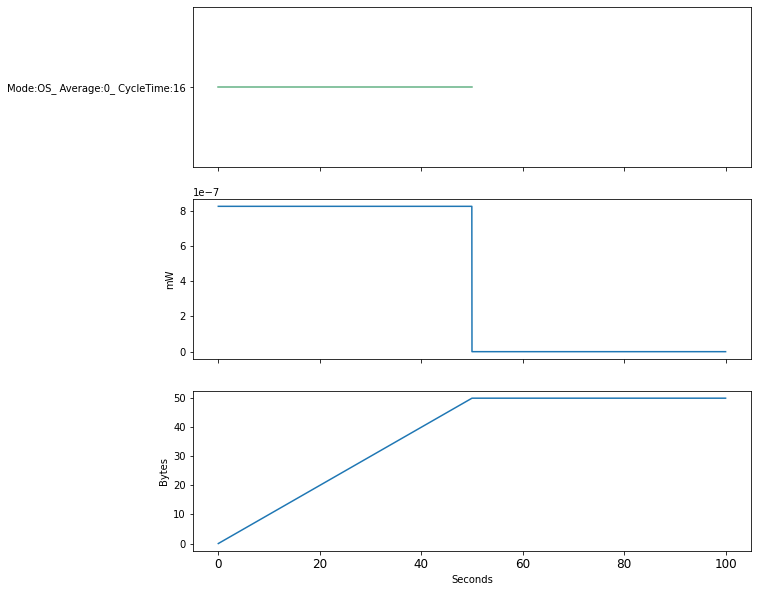

In [159]:
plotData(power, data, time, activeTimes)